In [1]:
import pandas as pd
import numpy as np

#df = pd.read_csv(r"C:\Users\kavya\Desktop\Kavya\Intelihub\client\HERC\Latest\data\model_ready_2.csv")

In [2]:
df = pd.read_csv(r"C:\Users\HP\Documents\Load_Forecasting_using_Fbprophet\Final Files fbprophet\Combined_Data_for_model_final_2.csv")

In [3]:
del df['Unnamed: 0']

#### Extracting Cal Features

In [4]:
df['Date'] = pd.to_datetime(df['Date'])

In [5]:
df = df[df['Date']>='2018-01-01']

In [6]:
df['month'] = pd.to_datetime(df['Date']).dt.month
df['weekday'] = pd.to_datetime(df['Date']).dt.weekday
df['hour'] = pd.to_datetime(df['Date']).dt.hour
df['hour_part'] = pd.to_datetime(df['Date']).dt.minute
df['year'] = pd.to_datetime(df['Date']).dt.year
df['day'] = pd.to_datetime(df['Date']).dt.day

# remove outliers in windspeed - checked the max windspeed India recorded - it is around 100
df = df[df['windspeed']<=100]

<AxesSubplot:>

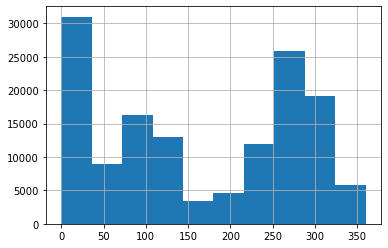

In [7]:
df['winddir'].hist()

In [8]:
def get_season(TimeSeries):
    
    season_list = []
    
    year_list = []
    month_list = []
    for time in TimeSeries:
        year = str(time)[:4]
        month = str(time)[5:7]
        year_list.append(year)
        month_list.append(month) 
       
    for m in month_list:
        if m=='01' or m=='02' or m=='12':
            season_list.append(0)   # Winter
        elif m=='03' or m=='04' or m=='05':
            season_list.append(1) #Spring-Summer
        elif m == '06' or m=='07':
            season_list.append(2) #Paddy/Monsoon
        elif m=='08' or m=='09':
            season_list.append(3) #Late Monsoon
        elif m=='10' or m=='11':
            season_list.append(4) #Autumn
            
    #season = pd.Series(season_list)
    return season_list

In [9]:
season = get_season(df['Date'])

In [10]:
df['Season'] = season

In [11]:
from sklearn import metrics
import numpy as np
from sklearn.model_selection import StratifiedKFold
import itertools
# from skopt import BayesSearchCV as bayes_opt

In [12]:
# check for 0 values and remove
df = df[df['Haryana Load (MW)']>0]

In [13]:
# Train Data
train = df[df['Date']<="2021-06-01"]

In [14]:
# Test Data
test = df[df['Date']>"2021-06-01"]

In [15]:
x_train = train[['month', 'hour', 'weekday', 'temp',
       'humidity', 'winddir', 'visibility', 'cloudcover',
       'hour_part', 'day', 'Season']]
y_train = train[['Haryana Load (MW)']]

In [16]:
x_test = test[['month', 'hour', 'weekday', 'temp',
       'humidity', 'winddir', 'visibility', 'cloudcover',
       'hour_part', 'day', 'Season']]
y_test = test[['Haryana Load (MW)']]

In [17]:
x_test.describe()

,month,hour,weekday,temp,humidity,winddir,visibility,cloudcover,hour_part,day,Season
count,20543.000000,20543.000000,20543.000000,20543.000000,20543.000000,20543.000000,20543.000000,20543.000000,20543.000000,20543.000000,20543.000000
mean,9.004819,11.500560,2.990751,26.290746,72.787525,144.249331,2.849107,44.337088,22.501095,15.790440,2.565448
std,1.998813,6.922058,1.988310,7.092862,19.693465,112.560636,1.105441,35.743741,16.770591,8.827231,1.298122
min,6.000000,0.000000,0.000000,5.000000,19.570000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,7.000000,6.000000,1.000000,21.400000,58.110000,40.000000,2.000000,0.000000,15.000000,8.000000,2.000000
50%,9.000000,12.000000,3.000000,28.000000,77.140000,120.000000,3.000000,50.000000,30.000000,16.000000,3.000000
75%,11.000000,17.500000,5.000000,31.000000,88.920000,260.000000,4.000000,86.500000,37.500000,23.000000,4.000000
max,12.000000,23.000000,6.000000,43.000000,100.000000,360.000000,9.000000,100.000000,45.000000,31.000000,4.000000


In [18]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [19]:
model = xgb.XGBRegressor()
model.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [20]:
preds = model.predict(x_test)

In [21]:
y_test['pred'] = preds

C:\Users\HP\AppData\Local\Temp/ipykernel_544/2190438978.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['pred'] = preds


In [22]:
from sklearn.metrics import r2_score
r2_score(y_test['Haryana Load (MW)'],y_test['pred'])

0.7243099006978692

In [23]:
from sklearn.ensemble import RandomForestRegressor

In [24]:
regr = RandomForestRegressor()

In [25]:
regr.fit(x_train, y_train)

C:\Users\HP\AppData\Local\Temp/ipykernel_544/1990009532.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(x_train, y_train)


RandomForestRegressor()

In [26]:
preds = model.predict(x_test)

In [27]:
y_test['pred'] = preds

C:\Users\HP\AppData\Local\Temp/ipykernel_544/2190438978.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['pred'] = preds


In [28]:
from sklearn.metrics import r2_score
r2_score(y_test['Haryana Load (MW)'],y_test['pred'])

0.7243099006978692

#### Inputs for CV Save

In [40]:
# x_train.to_csv('x_train_ncv.csv')
# y_train.to_csv('y_train_ncv.csv')
# x_test.to_csv('x_test_ncv.csv')
# y_test.to_csv('y_test_ncv.csv')

In [42]:
# X = df[['month', 'hour', 'weekday', 'temp',
#        'humidity', 'winddir', 'visibility', 'cloudcover',
#        'hour_part', 'day', 'Season']]
# Y = df[['Haryana Load (MW)']]

#### Bucket Analysis

In [209]:
len(x_train)

119709

In [210]:
train_predictions = model.predict(x_train)

In [211]:
y_train = y_train.reset_index().drop(columns='index')

In [212]:
y_train_with_error = y_train.join(pd.Series(train_predictions, name='preds'))

In [213]:
y_train_with_error['Error'] = y_train_with_error['Haryana Load (MW)'] - y_train_with_error['preds']

In [214]:
y_train_with_error['Percent Error'] = y_train_with_error['Error']*100/y_train_with_error['Haryana Load (MW)']

In [215]:
y_errorful_buckets = y_train_with_error[np.abs(y_train_with_error['Percent Error']) > 8]

In [216]:
x_train = x_train.reset_index().drop(columns='index')

In [217]:
y_errorful_buckets.index

Int64Index([    28,     29,     30,     32,     33,     37,     38,     39,
                46,     47,
            ...
            119699, 119700, 119701, 119702, 119703, 119704, 119705, 119706,
            119707, 119708],
           dtype='int64', length=29051)

In [218]:
x_train_new = x_train.drop(index = y_errorful_buckets.index)

In [219]:
x_train_new

,month,hour,weekday,temp,humidity,winddir,visibility,cloudcover,hour_part,day,Season
0,1,0,0,11.0,87.48,0.0,1.0,0.0,0,1,0
1,1,0,0,11.0,87.48,0.0,1.0,0.0,15,1,0
2,1,0,0,11.0,87.48,0.0,1.0,0.0,30,1,0
3,1,0,0,11.0,87.48,0.0,1.0,0.0,45,1,0
4,1,1,0,10.0,87.38,0.0,1.0,0.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
119694,5,20,0,33.5,49.88,110.0,4.0,0.0,30,31,1
119695,5,20,0,33.5,49.88,110.0,4.0,0.0,45,31,1
119696,5,21,0,34.0,41.27,120.0,4.0,27.4,0,31,1
119697,5,21,0,34.0,41.27,120.0,4.0,27.4,15,31,1


In [220]:
y_train_new = y_train.drop(index = y_errorful_buckets.index)

In [221]:
len(y_train_new)

90658

In [222]:
model2 = RandomForestRegressor()

In [223]:
model2.fit(x_train_new, y_train_new)

C:\Users\HP\AppData\Local\Temp/ipykernel_544/3869831522.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model2.fit(x_train_new, y_train_new)


RandomForestRegressor()

In [224]:
preds2 = model2.predict(x_test)

In [225]:
preds2

array([7093.5572, 7083.5986, 7071.0847, ..., 4488.2389, 4460.7384,
       4411.6041])

In [226]:
from sklearn.metrics import r2_score
r2_score(y_test['Haryana Load (MW)'], preds2)

0.7310649711714532

#### R2 = 0.731, when error threshold = 8%

#### R2 = 0.7305, when error threshold = 9%

In [208]:
len(preds2)

20543

#### Analyze Errorful buckets

In [170]:
y_errorful_buckets

,Haryana Load (MW),preds,Error,Percent Error
28,5625.73,4981.362305,644.367695,11.453939
29,5558.89,4962.998535,595.891465,10.719612
30,5467.75,4977.129395,490.620605,8.972989
32,4587.46,5031.809082,-444.349082,-9.686168
33,4567.14,5034.720215,-467.580215,-10.237922
...,...,...,...,...
119704,4506.24,6091.851074,-1585.611074,-35.187009
119705,4176.59,6109.577148,-1932.987148,-46.281468
119706,3976.80,6100.063965,-2123.263965,-53.391268
119707,3819.15,6101.098633,-2281.948633,-59.750170
